# Machine learning on networks

## Imports and defining functions

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from networkx.classes.graph import Graph
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from node2vec import Node2Vec

In [2]:
def compute_network_features(G: Graph) -> dict:
    """
   Computes node related features for a given graph G.
   Currently computes: Node degree, average neighbours, betweeness, eigenvector and closeness centrality, and the clustering coefficient

    Parameters
    ----------
    G : nx.Graph
        Graph to compute features

    Returns
    -------
    result_dict
        Dictionary with key as feature name and values as a dictionary of {index -> feature value}
    """

    result_dict = {}

    result_dict["degree"] = dict(G.degree())
    result_dict["average_nb_degree"] = nx.average_neighbor_degree(G)
    result_dict["betweeness"] = nx.betweenness_centrality(G)
    result_dict["eigenvector"] = nx.eigenvector_centrality_numpy(G) # Using the other implementation returned convergence errors
    result_dict["closeness"] = nx.closeness_centrality(G)
    result_dict["clustering"] = nx.clustering(G)

    return result_dict

def network_features_from_matrix(corr_matrix: np.ndarray, threshold: float) -> pd.DataFrame:
    """
   Computes node related features for a given correlation matrix.
   Meant to abstract the need to build and store multiple graphs considering multiple cutpoints for the correlation

    Parameters
    ----------
    corr_matrix: np.ndarray
       NxN matrix holding the pairwise correlation between each observation
    threshold: float
        Correlation cutoff point, values >= than this will be considered connected on the Graph

    Returns
    -------
    features_df: pd.DataFrame
        Dataframe holding the features computed from building the graph from the correlation matrix
    """

    adj_matrix = np.where(np.abs(corr_matrix)>=threshold, 1, 0)
    
    G = nx.from_numpy_array(adj_matrix)

    features_dict = compute_network_features(G)

    features_df = pd.DataFrame.from_dict(features_dict)

    aux_name = int(threshold*100)
    features_df.columns = [f"{col}_{aux_name}" for col in features_df.columns]

    return G, features_df

def create_node2vec_features(G: Graph) -> np.ndarray:
    """
    Creates Node2Vec embeddings for a given graph, returning the matrix with the vectors for each node

    Parameters
    ----------
    G: nx.Graph
       Graph built from a correlation matrix.

    Returns
    -------
    vectors: np.ndarray
        Embedding vectors where each line corresponds to the results for a single node.
    """

    n2v = Node2Vec(G, dimensions=32, workers=1)

    model = n2v.fit(window=10, min_count=1, batch_words=4)

    return model.wv.vectors

## Read data

In [3]:
df = pd.read_csv("data/Customer-Churn-Records.csv")

df.drop(columns=["RowNumber", "CustomerId", "Surname"], inplace=True) # Dropping ID colunms

is_missing = df.isna().sum()

### Checking if any column has missing values

In [4]:
for col, v in is_missing.items():
    if v>0:
        print(col)

### Checking class distribution

In [5]:
df["Exited"].mean()

0.2038

## Generating networks

We can build a network based on the pairwise correlation between observations.

To do this, we first drop the columns with the target variable, categorical variables, and transpose the data frame.

In [6]:
df = pd.get_dummies(df, columns=["Geography", "Gender", "Card Type"])

X, y = df.drop(columns="Exited"), df["Exited"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1)

### Computing correlations

To compute the "sample-wise" correlations, we normalize the data by using a PCA transformed version of the dataset.

While this is not required, it unskews the correlations matrix, centering it on 0, and therefore, generating smaller networks that are quicker to extract the attributes from.

Finally, we use `spearman` correlation since each PCA vector is un-correlated with the other, through linear correlation.

In [7]:
pca = PCA()

X_train_pca = pca.fit_transform(X_train)
X_full_pca = pca.fit_transform(X)

In [8]:
train_corr_matrix = pd.DataFrame(X_train_pca).T.corr(method="spearman").values
skewed_corr_matrix = X_train.T.corr(method="spearman").values
full_corr_matrix = pd.DataFrame(X_full_pca).T.corr(method="spearman").values

# To avoid self loops we fill the diagonal, inplace, with 0s
np.fill_diagonal(train_corr_matrix, 0)
np.fill_diagonal(skewed_corr_matrix, 0)
np.fill_diagonal(full_corr_matrix, 0)

#### Visualizing the correlations

Visualizing the unskewness effect of the PCA transformation

In [9]:
upper_diagonal = np.triu(train_corr_matrix)
upper_diagonal = upper_diagonal[np.abs(upper_diagonal)>0]

skew_upper_diagonal = np.triu(skewed_corr_matrix)
skewed_corr_matrix = skewed_corr_matrix[np.abs(skewed_corr_matrix)>0]

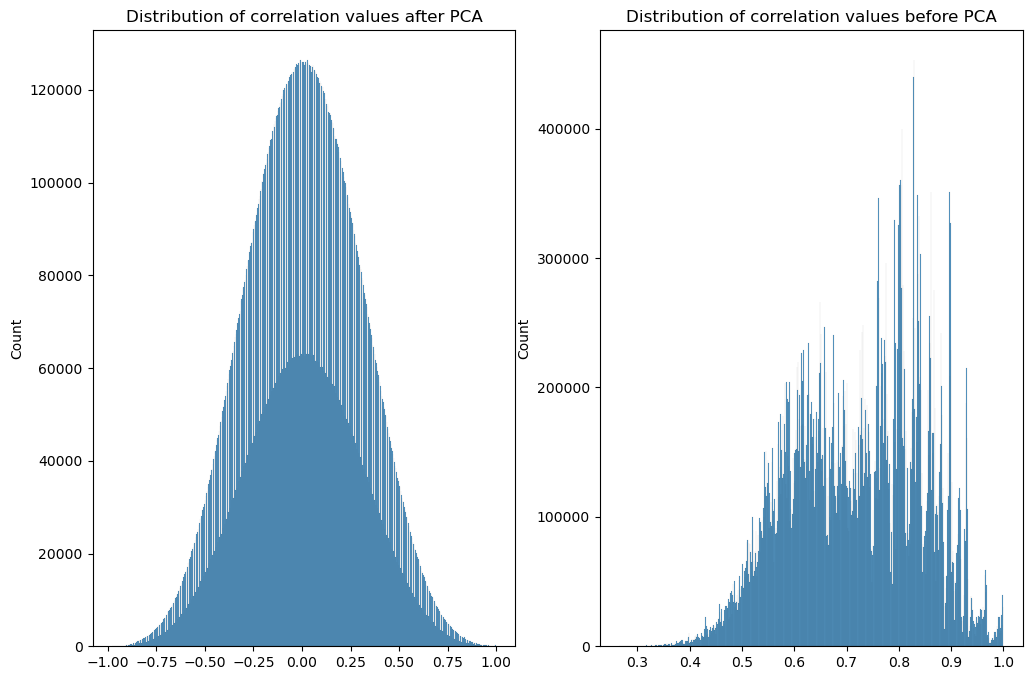

In [10]:
fig, ax = plt.subplots(ncols=2, figsize=(12,8))

sns.histplot(x=upper_diagonal, ax=ax[0])
sns.histplot(x=skewed_corr_matrix, ax=ax[1])

ax[0].set_title("Distribution of correlation values after PCA")
ax[1].set_title("Distribution of correlation values before PCA")
plt.show()

### Creating features

Candidates for computation are:
* Degree
* Average neighbors degree
* Centrality metrics (Betweeness, eigen and closeness)
* Clustering coefficient

The idea is to test as features at least 3 thresholds for correlations: 0.9, 0.8 and 0.7

In [11]:
train_file_name = "data/train_network_features.csv"
if os.path.isfile(train_file_name):
    train_nw_features = pd.read_csv(train_file_name)
else:
    train_nw_features_list = []
    for t in tqdm([0.9, 0.8, 0.7]):
        _, features = network_features_from_matrix(train_corr_matrix, t)
        train_nw_features_list.append(features)
    train_nw_features = pd.concat(train_nw_features_list, axis=1)
    train_nw_features.to_csv(train_file_name, index=False)

  0%|          | 0/3 [00:00<?, ?it/s]

In [13]:
full_file_name = "data/full_network_features.csv"
full_graph_dict = {}
if os.path.isfile(full_file_name):
    full_nw_features = pd.read_csv(full_file_name)
    for t in ([0.9, 0.8, 0.7]):
        adj_matrix = np.where(np.abs(full_corr_matrix)>=t, 1, 0)
        full_g = nx.from_numpy_array(adj_matrix)
        full_graph_dict[t] = full_g
else:
    full_nw_features_list = []
    for t in tqdm([0.9, 0.8, 0.7]):
        full_g, features = network_features_from_matrix(full_corr_matrix, t)
        full_nw_features_list.append(features)
        full_graph_dict[t] = full_g
    full_nw_features = pd.concat(full_nw_features_list, axis=1)
    full_nw_features.to_csv("data/full_network_features.csv", index=False)

  0%|          | 0/3 [00:00<?, ?it/s]

### Visualizing one network
Taking one of the graphs, we see a cluster of well conected nodes on the center, and on the outside, small communities.

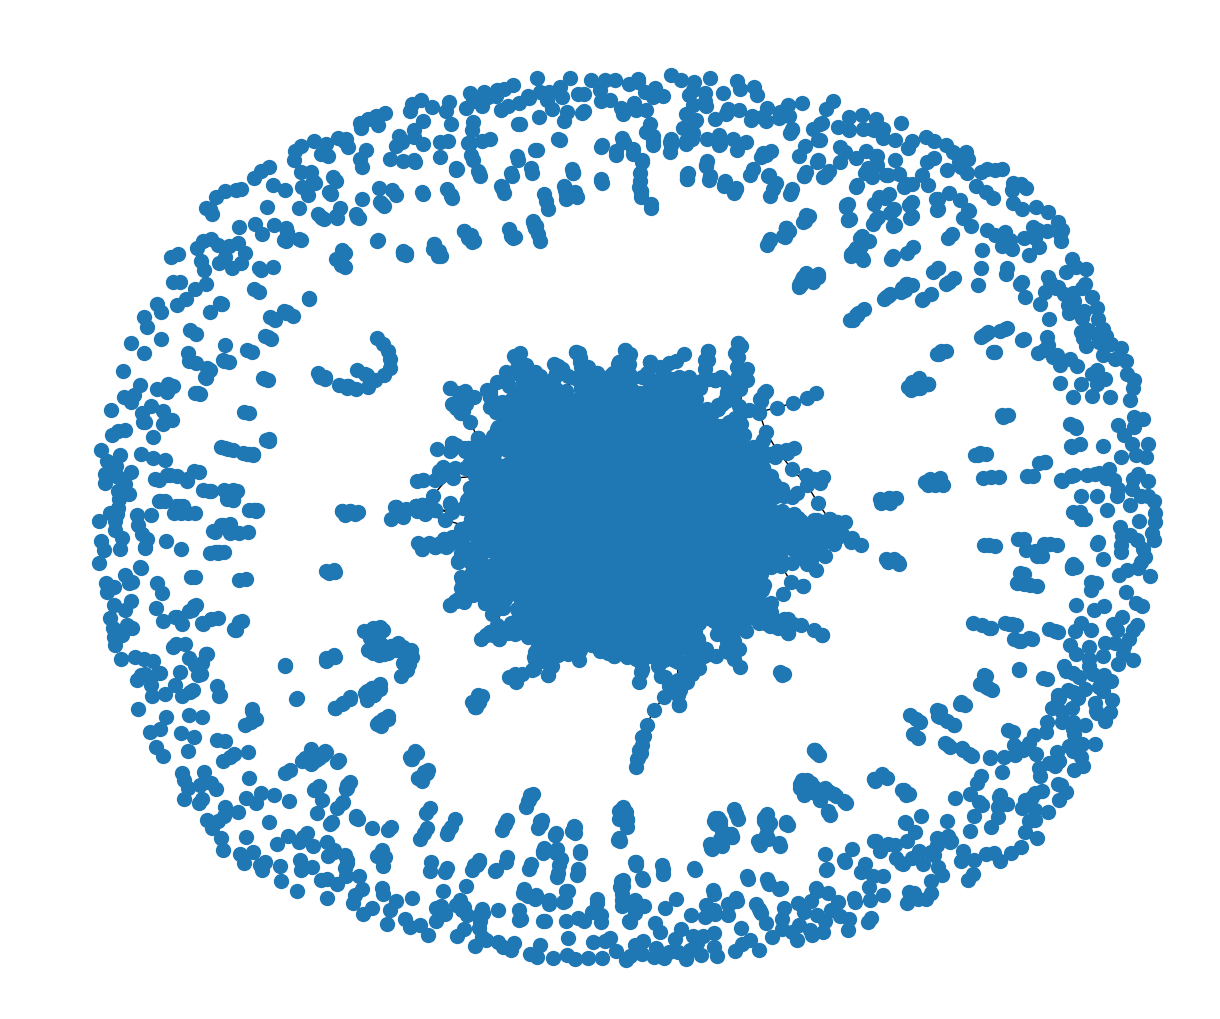

In [46]:
plt.figure(figsize=(12,10))
nx.draw(full_graph_dict[0.9], node_size=100)

plt.show()

#### Node2Vec

For node2vec features we make an assumption similar to word2vec, where, we understand that we have enough samples to learn the embeddings on the full set without generating leaks on the final task.

In [14]:
n2v_df_list = []
n2v_file_name = "data/n2v_embeddings.csv"

if os.path.isfile(n2v_file_name):
    n2v_df = pd.read_csv(n2v_file_name)
else:
    for t, g in full_graph_dict.items():
        n2v_embds = create_node2vec_features(g)
        aux_name = int(t*100)
        aux_df = pd.DataFrame(n2v_embds, columns=[f"n2v_{aux_name}_{i}" for i in range(32)])
        n2v_df_list.append(aux_df)
    n2v_df =  pd.concat(n2v_df_list, axis=1)
    n2v_df.to_csv(n2v_file_name, index=False)

In [15]:
del train_corr_matrix, full_corr_matrix, skewed_corr_matrix

## Training and evaluating models

The train network features index mismatch with the dataset, however, in the case of the full dataset, we can just join because we computed on the input ordering

In [16]:
X_train = (
    X_train
        .reset_index(drop=True)
        .join(train_nw_features)
        .join(n2v_df)
)

X_test = (X_test
          .join(full_nw_features)
          .join(n2v_df)
        )

In [17]:
def train_evaluate_model(
        X_train: pd.DataFrame,
        y_train: pd.Series,
        X_test: pd.DataFrame,
        y_test: pd.Series,
        features: list,
        seed: int = 1
        ):
    
    rf = RandomForestClassifier(random_state=seed)

    rf.fit(X_train[features], y_train)
    predictions = rf.predict_proba(X_test[features])[:, 1]

    score = roc_auc_score(y_test, predictions)

    return score

### Training loop

We will test different features sets, starting from the original features, given by the dataset, to the computed network metrics for different correlation thresholds.

Finally, we will also test how well a model will perform when trained on all possible features.

The models will be evaluated using ROC-AUC due to being an unbalanced classification task.

In [18]:
# Complain feature is probably leaking into the test data, and its presence yields a ROC-AUC score of 99%
full_feature_set = list(X_train.drop(columns="Complain").columns)

experiments = {
    "original_set": [col for col in full_feature_set if "0" not in col],
    "nw_70": [col for col in full_feature_set if "70" in col],
    "nw_80": [col for col in full_feature_set if "80" in col],
    "nw_90": [col for col in full_feature_set if "90" in col],
    "nw_full_set": [col for col in full_feature_set if "0" in col],
    "full_features": full_feature_set
}

In [19]:
roc_auc_scores = {}

for e, features in experiments.items():
    print(f"Starting {e}...")
    roc_auc_scores[e] = train_evaluate_model(X_train, y_train, X_test, y_test, features)

Starting original_set...
Starting nw_70...
Starting nw_80...
Starting nw_90...
Starting nw_full_set...
Starting full_features...


### Evaluation

It seems that using the network features do not provide any meaningful value to the original set, and does not surpass the validation AUC from the original feature space.

However, there are some interesting findings, such as, the network built using the 0.7 cut point performs best when compared to all models trained on its own network features.

There is the open question of how different model algorithms, or even hyperparameter tuning, would help shape the outcomes.

In [20]:
scores_df = (
    pd.DataFrame
        .from_dict(roc_auc_scores, orient="index")
        .reset_index()
        .rename(columns={"index": "feature_set", 0: "roc_auc"})
        .assign(diff=lambda x: x["roc_auc"]-x["roc_auc"].iloc[0],
                sign=lambda x: np.where(x["diff"]>=0, "up", "down")
                )
    )

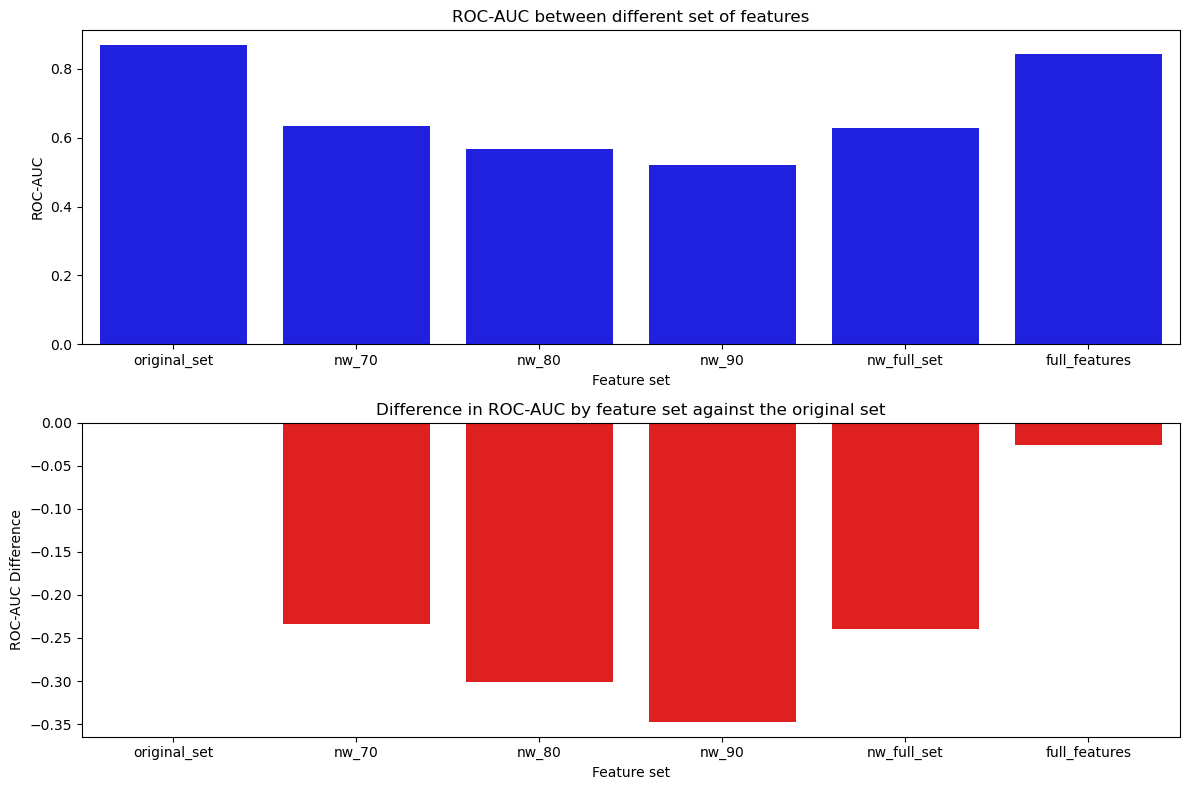

In [21]:
fig, axs = plt.subplots(nrows=2, figsize=(12,8))

axs[0] = sns.barplot(x="feature_set", y="roc_auc", data=scores_df, color="blue", ax=axs[0])
axs[0].set_title("ROC-AUC between different set of features")
axs[0].set_xlabel("Feature set")
axs[0].set_ylabel("ROC-AUC")

sns.barplot(x="feature_set", y="diff", hue="sign", data=scores_df, ax=axs[1], dodge=False, palette=["green", "red"])
axs[1].set_title("Difference in ROC-AUC by feature set against the original set")
axs[1].set_xlabel("Feature set")
axs[1].set_ylabel("ROC-AUC Difference")
axs[1].get_legend().remove()

plt.tight_layout()
plt.show()

## Feature importance

We can also check the standard Gini feature importance of the features to see how the contribution of the network features

In [22]:
rf = RandomForestClassifier(random_state=1)

rf.fit(X_train[full_feature_set], y_train)

RandomForestClassifier(random_state=1)

In [23]:
feature_importance = (pd.DataFrame({"feature": X_train[full_feature_set].columns, "importance": rf.feature_importances_})
                      .sort_values(by="importance", ascending=False))

A good number of network related features show up on the top 20, mostly related to centrality statistics of the network. However, they do not seems to hold such an impact as **Age** and **NumOfProducts** from the original set or aren't able to extrapolate the learnt splits on the validation set.

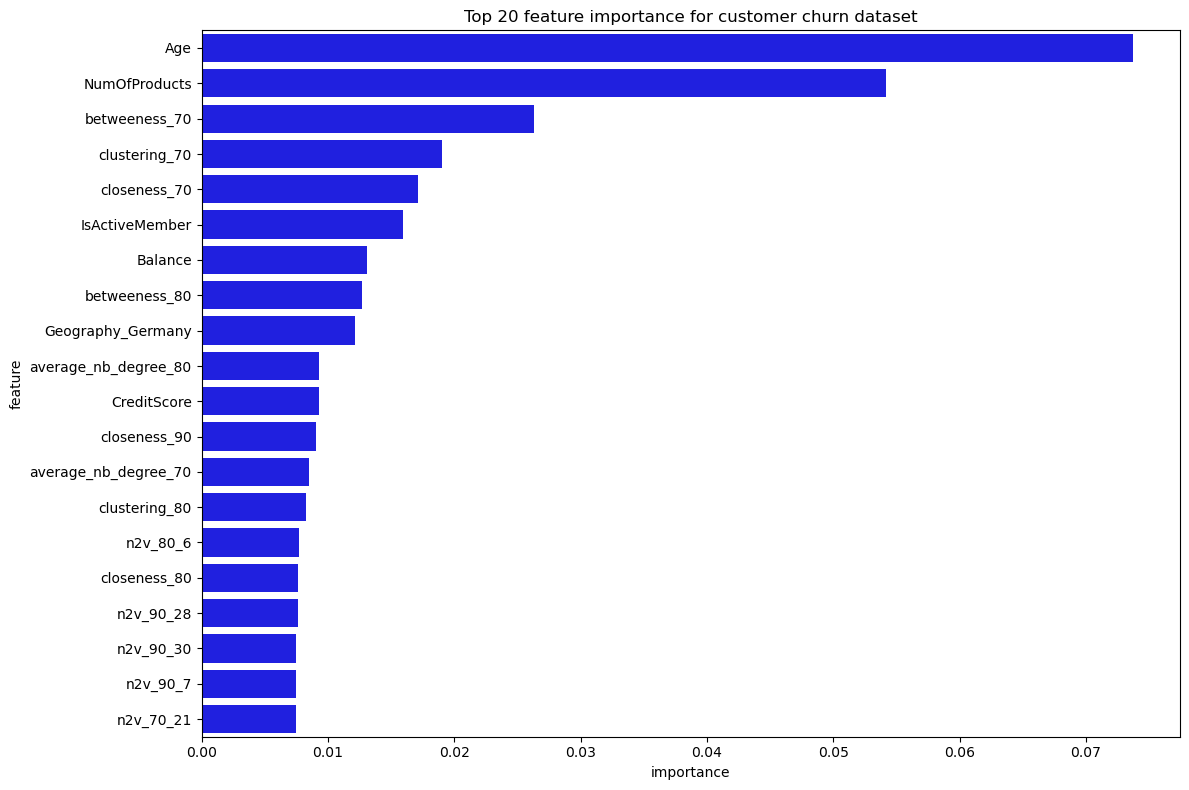

In [24]:
fig, ax = plt.subplots(figsize=(12,8))

sns.barplot(x="importance", y="feature", color="blue", data=feature_importance.iloc[:20], orient="h", ax=ax)


ax.set_title("Top 20 feature importance for customer churn dataset")
plt.tight_layout()
plt.show()